# TP Data Science - Apprentissage Surpevisé


## Etude du jeu de données "BreastCancer"

In [32]:
# Import des librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import graphviz
plt.ion()

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
plt.style.use('ggplot')

### Données

In [47]:
# Import
df_cancer = pd.read_csv('data/df_breastCancer.csv', delimiter = ';')
df_cancer.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Le dataset est composé de **30 features** et **569 observations**. Chacune d'elle est étiquettée par la la colonne "diagnostic" qui indique si l'entrée observée était bénine ou maligne.

Les features peuvent être vues comme 3 ensembles de 10 types d'observations. Le dataset est en effet composé de la valeur moyenne (mean), l'erreur standard (se) et la pire valeur (worst).

On remarque donc que certaines features peuvent signifier la même chose. Pour réaliser une analyse fiable, il sera nécessaire de réduire le nombre de features en se basant sur la pertinence et les corrélations de chacune.

In [8]:
# Séparation valeurs et diagnostic
X = df_cancer.drop('diagnosis', axis = 1)
y = df_cancer.diagnosis

# Codage des catégories. B = 0, M = 1
y = y.replace('B', 0)
y = y.replace('M', 1)

df_cancer.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

### Sélection des features


#### Visualisation des variables

On peut tout d'abord essayer de déterminer visuellement les features qui semblent le moins pertinentes. L'idée est de conserver les features qui fournissent une séparation nette entre les deux classes.

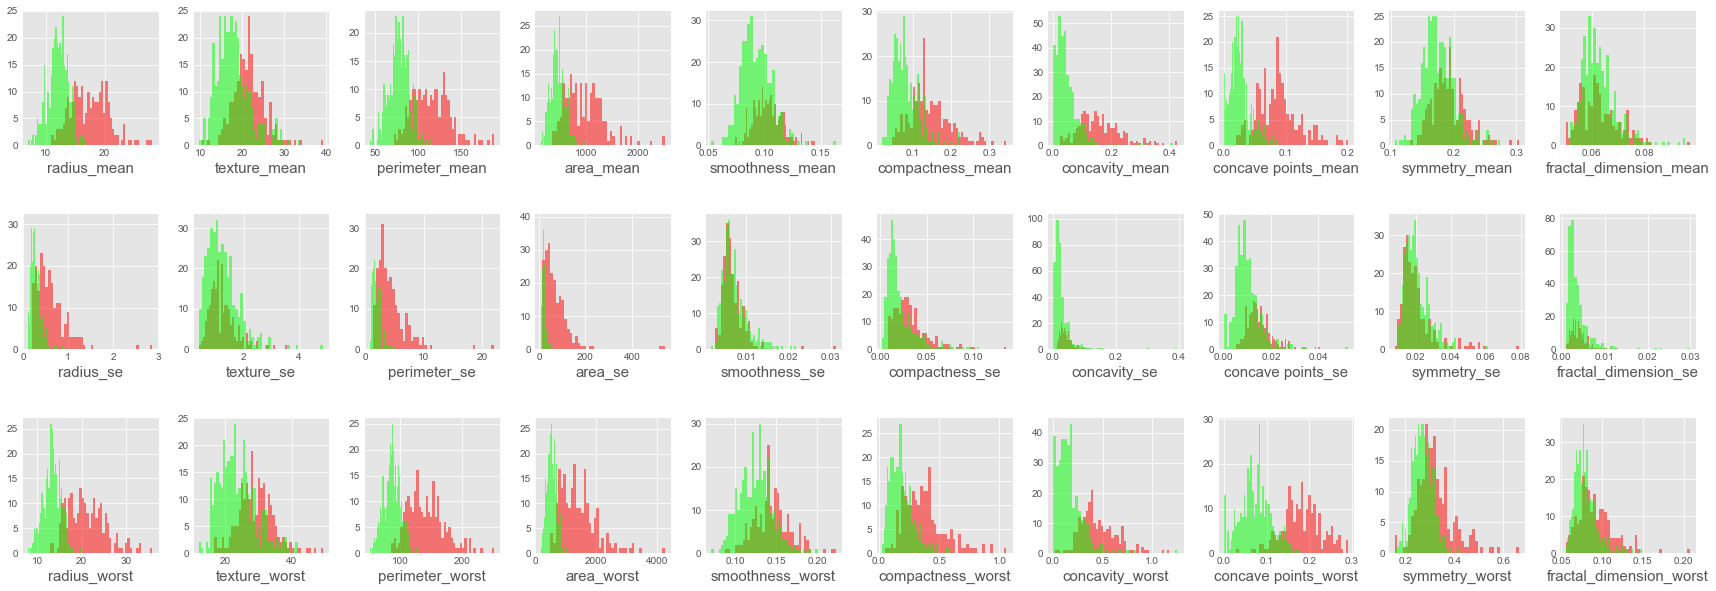

In [51]:
# Historgrammes
fig, axs = plt.subplots(3, 10, figsize=(30, 10))
fig.subplots_adjust(hspace = .5, wspace=.25)
axs = axs.ravel()

for i, c in enumerate(X.columns):
    m = axs[i].hist(X[y == 1][c],bins=45,fc = (1,0,0,0.5))
    b = axs[i].hist(X[y == 0][c],bins=45,fc = (0,1,0,0.5))
    axs[i].set_xlabel(c, fontsize=15)

In [10]:
# Sélection d'après histogrammes :
drop_features_hist = ['texture_se', 'smoothness_se', 'concavity_se', 'fractal_dimension_se']

X_selected_hist = X.drop(drop_features_hist, axis=1)

#### Multi-corrélations
La figure suivante montre que beaucoup de features ont des facteurs de corrélation positifs et proches de 1. Cela signifie que ces paramètres expliquent la même chose que les autres. L'idéal serait donc de s'en débarrasser pour améliorer la performance du modèle.

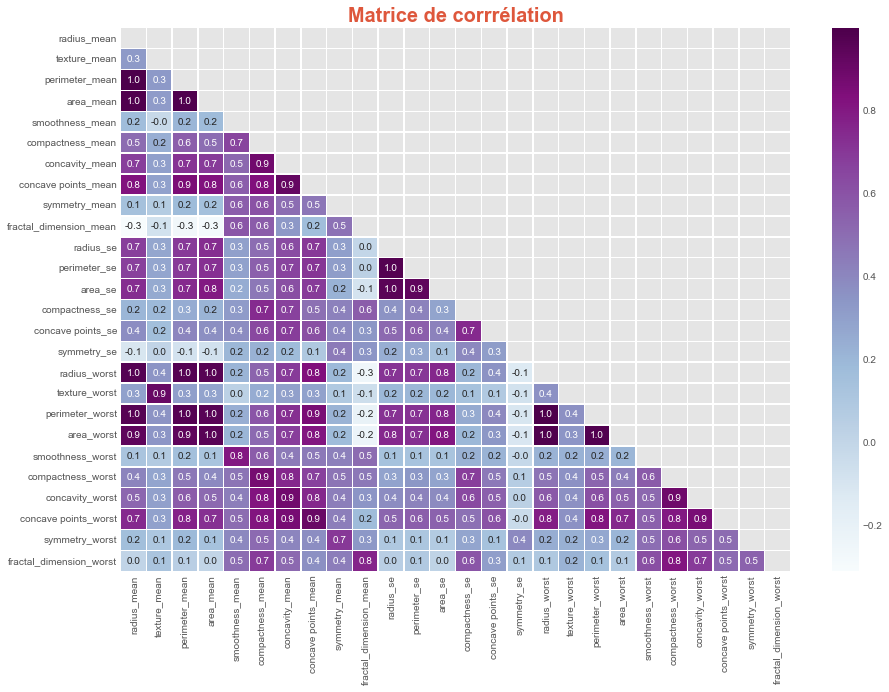

In [35]:
correlations = X_selected_hist.corr()
masque = np.triu(np.ones_like(correlations, dtype = bool))

plt.figure(figsize=(15, 10))
sns.heatmap(correlations,
            mask = masque,
            cmap = 'BuPu',
            annot = True,
            linewidths = 0.5,
            fmt = ".1f")

plt.title('Matrice de corrrélation',
          fontsize = 20,
          weight = 'semibold',
          color = '#de573c'
         )

plt.show()

#### Facteur d'Inflation de Variance (VIF)
On utilise le Facteur d'Inflation de Variance pour déterminer les features qui font l'objet d'une trop grande multi-colinéarité. Si le VIF d'un paramètre dépasse 10, alors celui-ci va réduire la fiabilité de notre modèle.

In [12]:
def VIF(df):
    vif = pd.DataFrame()
    vif['feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, col) for col in range(len(df.columns))]
    return vif

vif_df = VIF(X_selected_hist).sort_values('VIF', ascending = False, ignore_index = True)
print(vif_df)

                    feature           VIF
0               radius_mean  60886.141538
1            perimeter_mean  55007.791360
2              radius_worst   9402.640307
3           perimeter_worst   4349.014859
4                 area_mean   1217.076935
5                area_worst   1094.275690
6    fractal_dimension_mean    616.228526
7           smoothness_mean    358.652223
8   fractal_dimension_worst    268.832151
9                 radius_se    215.314071
10         smoothness_worst    207.073506
11         compactness_mean    199.284605
12             perimeter_se    193.345602
13             texture_mean    183.069887
14           symmetry_worst    179.647965
15            texture_worst    174.171736
16            symmetry_mean    173.471509
17     concave points_worst    140.724656
18      concave points_mean    129.572748
19           concavity_mean    117.599018
20        compactness_worst    108.905480
21          concavity_worst     75.414122
22                  area_se     67

Les valeurs sont toutes grandement supérieures à 5 (borne acceptable). On peut choisir de conserver les features dont le VIF ne dépasse pas 10000.
On peut également choisir de retirer une feature trop corrélée avec une autre (exemple : texture_worst et texture_mean).  

In [52]:
# Sélection des features dont le vif est inférieur à la borne fixée
borne = 10000
drop_features_vif = vif_df[vif_df['VIF'] > borne].feature
X_selected_vif = X_selected_hist.drop(drop_features_vif, axis=1)
X_selected_vif = X_selected_vif.drop('texture_mean', axis=1)

In [14]:
# Features conservées :
print('Features conservées :', X_selected_vif.columns.values)
print('{}/{} features ont été conservées.'.format( len(X_selected_vif.columns), len(X.columns)))

Features conservées : ['area_mean' 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'perimeter_se' 'area_se' 'compactness_se' 'concave points_se'
 'symmetry_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst']
23/30 features ont été conservées.


### Découpage entre données d'apprentissage (66%) et de test (33%)

In [53]:
# Normalisation des valeurs :
X_selected = StandardScaler().fit_transform(X_selected_vif)

# Découpage trainset / testset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33)
print(len(X_train),'données d\'apprentissage')
print(len(X_test),'données de test')

381 données d'apprentissage
188 données de test


Notre analyse sera portée sur les méthodes suivantes :
- Modèle Linéaire
- Perceptron Multicouche
- Decision Tree

## Modèle linéaire

### Entrainement

In [54]:
# Initialisation du modèle
lda = LinearDiscriminantAnalysis()

# Entrainement
lda.fit(X_train, y_train)

# Evaluation des performances
ldaScore_train = "%.3f" % lda.score(X_train, y_train)
ldaScore_test = "%.3f" % lda.score(X_test, y_test)

print("Train:",ldaScore_train)
print("Test:",ldaScore_test)

Train: 0.969
Test: 0.952


### Mesures d'évaluation

In [17]:
def printEval(predict_train, expected_train, predict_test, expected_test):
    _eval = precision_recall_fscore_support(expected_train, predict_train, average=None)
    print("Train")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))
    
    _eval = precision_recall_fscore_support(expected_test, predict_test, average=None)
    print("Test")
    print("  - Precision 0 :", _eval[0][0].round(3))
    print("  - Precision 1 :", _eval[0][1].round(3))
    print("  - Recall 0 :", _eval[1][0].round(3))
    print("  - Recall 1 :", _eval[1][1].round(3))
    print("  - F-mesure 0 :", _eval[2][0].round(3))
    print("  - F-mesure 1 :", _eval[2][1].round(3))

In [18]:
printEval(lda.predict(X_train), y_train, lda.predict(X_test), y_test)

Train
  - Precision 0 : 0.95
  - Precision 1 : 0.993
  - Recall 0 : 0.996
  - Recall 1 : 0.921
  - F-mesure 0 : 0.972
  - F-mesure 1 : 0.955
Test
  - Precision 0 : 0.927
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 0.836
  - F-mesure 0 : 0.962
  - F-mesure 1 : 0.911


### Courbe ROC
<a id='roc_lda'></a>

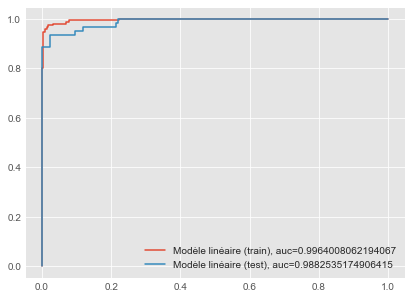

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
# AUC-ROC des données train :
y_pred_LDA_train = lda.predict_proba(X_train)[::,1]
fpr_LDA_train, tpr_LDA_train, _ = roc_curve(y_train, y_pred_LDA_train)
auc_LDA_train = roc_auc_score(y_train, y_pred_LDA_train)

# AUC-ROC des données test :
y_pred_LDA = lda.predict_proba(X_test)[::,1]
fpr_LDA, tpr_LDA, _ = roc_curve(y_test, y_pred_LDA)
auc_LDA = roc_auc_score(y_test, y_pred_LDA)

# Affichage courbe ROC + AUC
plt.plot(fpr_LDA_train,tpr_LDA_train,label="Modèle linéaire (train), auc="+str(auc_LDA_train))
plt.plot(fpr_LDA,tpr_LDA,label="Modèle linéaire (test), auc="+str(auc_LDA))
plt.legend(loc=4);

## Modèle PMC

### Entrainement

In [23]:
# PMC par défaut
defaultPMC = MLPClassifier(max_iter=1500)

# PMC personnalisé
modelPMC = MLPClassifier(activation='relu',max_iter=5000, learning_rate_init=1e-5, alpha=1e-2,
                         epsilon = 1e-10,
                         hidden_layer_sizes=(300,300,200), solver='adam')

# Entrainement
defaultPMC.fit(X_train, y_train)
modelPMC.fit(X_train, y_train)

# Evaluation des performances
defaultPMC_score_train = "%.3f" % defaultPMC.score(X_train, y_train)
defaultPMC_score_test = "%.3f" % defaultPMC.score(X_test, y_test)

modelPMC_score_train = "%.3f" % modelPMC.score(X_train, y_train)
modelPMC_score_test = "%.3f" % modelPMC.score(X_test, y_test)

print("PMC par défaut :")
print(" - Train:",defaultPMC_score_train)
print(" - Test:",defaultPMC_score_test)

print("PMC personnalisé :")
print(" - Train:",modelPMC_score_train)
print(" - Test:",modelPMC_score_test)

PMC par défaut :
 - Train: 0.997
 - Test: 0.973
PMC personnalisé :
 - Train: 0.987
 - Test: 0.984


In [50]:
print("Default PMC : ")
printEval(defaultPMC.predict(X_train), y_train, defaultPMC.predict(X_test), y_test)
print("\nPMC personnalisé : ")
printEval(modelPMC.predict(X_train), y_train, modelPMC.predict(X_test), y_test)

Default PMC : 
Train
  - Precision 0 : 0.996
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 0.993
  - F-mesure 0 : 0.998
  - F-mesure 1 : 0.997
Test
  - Precision 0 : 0.969
  - Precision 1 : 0.983
  - Recall 0 : 0.992
  - Recall 1 : 0.934
  - F-mesure 0 : 0.981
  - F-mesure 1 : 0.958

PMC personnalisé : 
Train
  - Precision 0 : 0.979
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 0.967
  - F-mesure 0 : 0.989
  - F-mesure 1 : 0.983
Test
  - Precision 0 : 0.977
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 0.951
  - F-mesure 0 : 0.988
  - F-mesure 1 : 0.975


### Coube ROC
<a id='roc_pmc'></a>

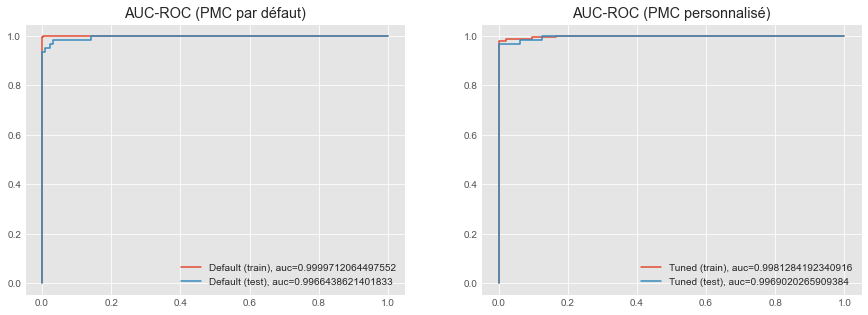

In [37]:
plt.figure(figsize=(15,5))

# AUC-ROC des données train :
y_pred_DefaultPMC_train = defaultPMC.predict_proba(X_train)[::,1]
y_pred_ModelPMC_train = modelPMC.predict_proba(X_train)[::,1]
fpr_DefaultPMC_train, tpr_DefaultPMC_train, _ = roc_curve(y_train,  y_pred_DefaultPMC_train)
fpr_ModelPMC_train, tpr_ModelPMC_train, _ = roc_curve(y_train,  y_pred_ModelPMC_train)
auc_DefaultPMC_train = roc_auc_score(y_train, y_pred_DefaultPMC_train)
auc_ModelPMC_train = roc_auc_score(y_train, y_pred_ModelPMC_train)

# AUC-ROC des données test :
y_pred_DefaultPMC = defaultPMC.predict_proba(X_test)[::,1]
y_pred_ModelPMC = modelPMC.predict_proba(X_test)[::,1]
fpr_DefaultPMC, tpr_DefaultPMC, _ = roc_curve(y_test,  y_pred_DefaultPMC)
fpr_ModelPMC, tpr_ModelPMC, _ = roc_curve(y_test,  y_pred_ModelPMC)
auc_DefaultPMC = roc_auc_score(y_test, y_pred_DefaultPMC)
auc_ModelPMC = roc_auc_score(y_test, y_pred_ModelPMC)

# Affichage courbe ROC + AUC
plt.subplot(1, 2, 1)
plt.plot(fpr_DefaultPMC_train,tpr_DefaultPMC_train,label="Default (train), auc="+str(auc_DefaultPMC_train))
plt.plot(fpr_DefaultPMC,tpr_DefaultPMC,label="Default (test), auc="+str(auc_DefaultPMC))
plt.title("AUC-ROC (PMC par défaut)")
plt.legend(loc=4)

plt.subplot(1, 2, 2)
plt.plot(fpr_ModelPMC_train,tpr_ModelPMC_train,label="Tuned (train), auc="+str(auc_ModelPMC_train))
plt.plot(fpr_ModelPMC,tpr_ModelPMC,label="Tuned (test), auc="+str(auc_ModelPMC))
plt.title("AUC-ROC (PMC personnalisé)")
plt.legend(loc=4);

## Arbre de décision

### Entrainement

In [73]:
# Initialisation du modèle
dt = tree.DecisionTreeClassifier()

# Entrainement
dt = dt.fit(X_train, y_train)

# Evaluation des performances
dtScore_train = "%.3f" % dt.score(X_train, y_train)
dtScore_test = "%.3f" % dt.score(X_test, y_test)

print("Train:",dtScore_train)
print("Test:",dtScore_test)
printEval(dt.predict(X_train), y_train, dt.predict(X_test), y_test)

Train: 1.000
Test: 0.931
Train
  - Precision 0 : 1.0
  - Precision 1 : 1.0
  - Recall 0 : 1.0
  - Recall 1 : 1.0
  - F-mesure 0 : 1.0
  - F-mesure 1 : 1.0
Test
  - Precision 0 : 0.925
  - Precision 1 : 0.941
  - Recall 0 : 0.965
  - Recall 1 : 0.877
  - F-mesure 0 : 0.945
  - F-mesure 1 : 0.908


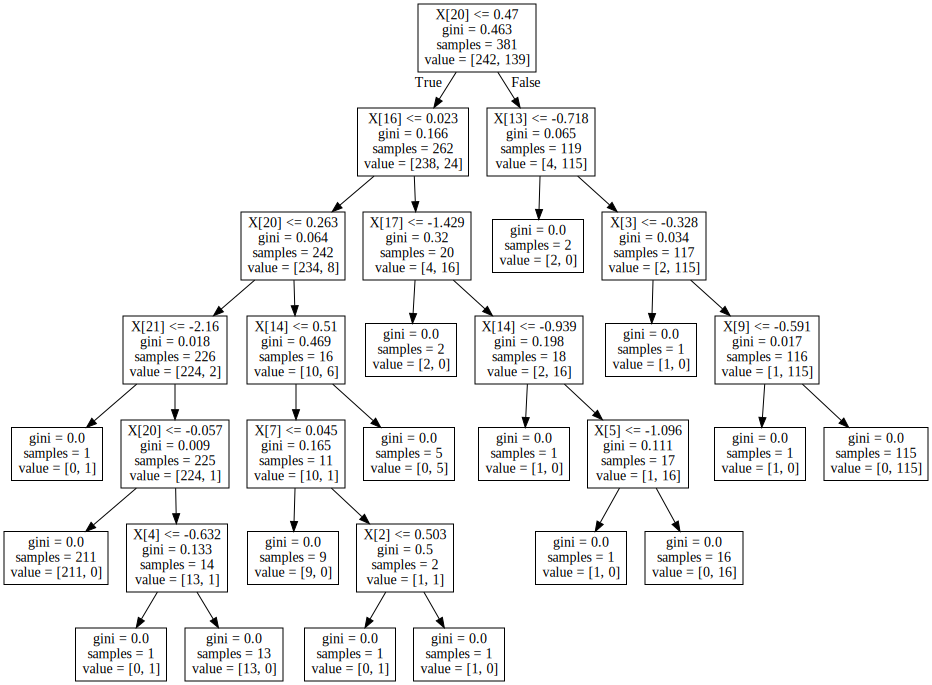

In [74]:
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data)
graph 

Grâce à cette visualisation, on peut déterminer quelle feature est la plus discriminante selon l'arbre de décision :

In [75]:
print("La feature '{}' se trouve en racine de l'arbre.".format(X_selected_vif.columns[20]))

La feature 'concave points_worst' se trouve en racine de l'arbre.


### Courbe ROC

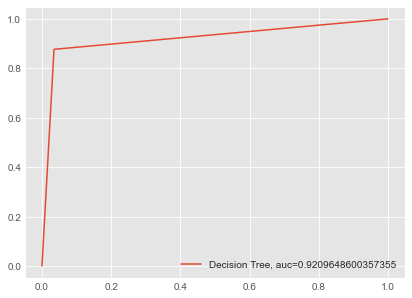

In [76]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
y_pred_proba_DT = dt.predict_proba(X_test)[::,1]
fpr_DT, tpr_DT, _ = roc_curve(y_test,  y_pred_proba_DT)
auc_DT = roc_auc_score(y_test, y_pred_proba_DT)
plt.plot(fpr_DT,tpr_DT,label="Decision Tree, auc="+str(auc_DT))
plt.legend(loc=4)

## Résultats

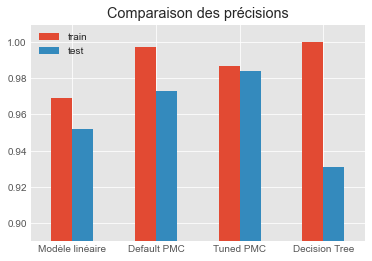

In [77]:
x = ["Modèle linéaire", "Default PMC", "Tuned PMC", "Decision Tree"]
train_scores = [ldaScore_train, defaultPMC_score_train, modelPMC_score_train, dtScore_train]
test_scores = [ldaScore_test, defaultPMC_score_test, modelPMC_score_test, dtScore_test]

df = pd.DataFrame(data={'train': train_scores, 'test': test_scores}, index=x)
df=df.astype(float)
ax = df.plot(kind='bar', rot=0, title='Comparaison des précisions', figsize=(6, 4))
ax.margins(y=0.1)
ax.set_ylim(0.89, 1.01);

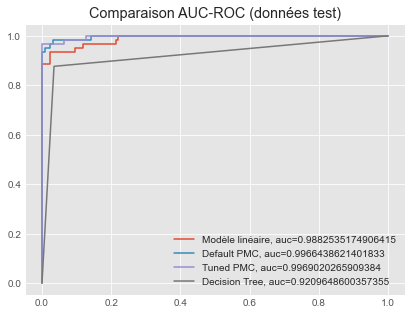

In [78]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(fpr_LDA,tpr_LDA,label="Modèle linéaire, auc="+str(auc_LDA))
plt.plot(fpr_DefaultPMC,tpr_DefaultPMC,label="Default PMC, auc="+str(auc_DefaultPMC))
plt.plot(fpr_ModelPMC,tpr_ModelPMC,label="Tuned PMC, auc="+str(auc_ModelPMC))
plt.plot(fpr_DT,tpr_DT,label="Decision Tree, auc="+str(auc_DT))
plt.legend(loc=4)
plt.title("Comparaison AUC-ROC (données test)");

**Observations** :

- Tout d'abord, on remarque que le modèle linéaire et les réseaux de neuronnes ont fourni de bons résultats (94% à 98% d'accuracy). L'arbre de décision a fourni la moins bonne précision (93%).

- La comparaison des courbes ROC et de l'aire sous la courbe (AUC) permettent de confirmer cette analyse. Les ROC des méthodes modèle linéaire et réseaux de neuronnes sont groupées, et leur AUC est très proche de 1. Cependant cette valeur est synthétique et ne reflète pas le sur-apprentissage.

- En effet, le modèle linéaire et le perceptron multi-couche par défaut ont fait l'objet d'un sur-apprentissage. On remarque en effet une accuracy supérieure de 2% sur le trainset. De plus, lorsque l'on regarde les courbes ROC du [modèle linéaire](#roc_lda) et [PMC par défaut](#roc_pmc), on observe une assez nette séparation entre la courbe train et test, ce qui témoigne un sur-apprentissage.

- Le modèle PMC personnalisé possède une meilleure accuracy et a réduit le sur-apprentissage ([Courbes ROC](#roc_pmc) plus groupées et accuracy test/train similaires)
<br>

**Conclusion** : Notre méthode de sélection de feature et l'utilisation d'un Perceptron Multi-Couche ont fourni de bonnes performances, tant au niveau de la généralisation que de la précision.